# Task 2

## Forecast 1 year ahead

Since the time series presents a non-stationary behaviour, using traditional techniques (such as ARIMA, linear regression ecc) may not provide accurate forecast. The alternative is to use non-linear models, such as Neural Networks (NN), which are able to capture intricate patterns or trends inside our data (this is achieved by applying non-linear transformation to the data and gradually updating the parameters of the models, improving the forecasting performance). Another reason to use them is that we're dealing with an univariate problem, thus there's no need to investigate which other variables have more influence on the main one.

Being a time series problem, we can use different NN architectures. In this case we'll test:
- Multi-layer Perceptron (MLP): the standard NN;
- Long-short Term Memory NN (LSTM): a special class of NN specifically designed fo tackling time series problems. However they require more computation power and they are more prone to overfitting when there are few observations.

One of each NN class will be implemented to compare the computation time and performance. 

In [1]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization, TimeDistributed
from keras.models import Model, Sequential

In [2]:
#os.chdir('C:\\Users\\loren\\xtreamassignment\\xtream-ai-assignment\\datasets\\italian-power-load')
load = 'load'
date = 'Date'

# define the column of interest
energy = 'Load'

# create the function to retrieve the data and set the date in a format that I prefer to work with (instead of uploadinf the dataset directly)

def retrieve_data(source):


    df = pd.read_csv((f"{source}.csv"), parse_dates = [date])

    df[date] = pd.to_datetime(df[date], utc=True, infer_datetime_format=True)

    df[date] = df[date].dt.strftime('%Y-%m-%d')

    df[date] = df[date].drop_duplicates()

    #df = df.sort_values(by=[date])

    df = df.set_index(pd.DatetimeIndex(df[date]))

    df = df.drop(columns=['Date'])

    return df

df = retrieve_data(load)

In [3]:
# Defining the plots for train/validation

def plot_model_rmse_and_loss(history):
    
    #evaluating train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #visualizing epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs / Training RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs / Training Loss')

    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted', color='red')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()

In [4]:
# I discard the yeras after 2019

data_task = df[:'2019']

In [5]:
# define the scalers that will be used
ss = StandardScaler()
mms = MinMaxScaler(feature_range=(0,1))

In [6]:
# I'll use 2018 as validation, 2019 as test and the remaining years as training

# I create a function to scale the original dataset and perform some feature engineering
def create_scaled_array(df, selected_column, stop_year, your_scaler):

    # Define the number of train observations
    n_train = len(df) - len(df[stop_year:])

    # Create the array of the observations
    feature_array = df[selected_column].values.reshape(-1,1)

    # Scale the features: it's helpful when dealing with NN to prevent underfitting
    scaler = your_scaler

    scaler.fit(feature_array[:n_train])
    scaled_array = scaler.transform(feature_array)

    return scaled_array

### MLP

In [7]:
# I create a function to process the previous scaled array in order to obtain a dataset with several lagged observation of the main variable and separate the actual values y

# the arguments are the scaled array, the column of the main variable and the name of the original df from which extract the index
def create_scaled_df(array, column_name, index_df):

    # Re-create the DataFrame from the scaled observations
    scaled_df = pd.DataFrame(array, columns=[column_name])

    # Create 7 lags and store them as new columns in the DataFrame. We'll consider them as our independent variables. The number could be chosen arbitrarily. 
    # I decided to go with 7 values by looking at the highest values of partial correlations (see above) 
    for i in range(1, 8):
        scaled_df[f'lag_{i}'] = scaled_df[column_name].shift(i)

    # Interpolate missing values
    scaled_df = scaled_df.bfill()

    # I take the same index as the original df
    scaled_df.index = index_df.index

    # Separate the lags (features) and the observation (target)
    X = scaled_df.drop(columns=[column_name], axis=1)

    y = scaled_df[column_name]

    return X, y

In [8]:
scaled_array = create_scaled_array(data_task, energy, '2018', ss)

In [9]:
X, y = create_scaled_df(scaled_array, energy, data_task)

In [10]:
# I create a function that creates train, validation and test for the MLP using the indexes of 2018 for validation and 2019 for test

def create_train_test_val(X, y, val_year, test_year):
    
    n_train = len(X) - len(X[val_year:])

    # Separate the features into training and test sets
    X_train, X_val, X_test = X[:n_train].reset_index().drop(columns=['Date'], axis=1), X[val_year].reset_index().drop(columns=['Date'], axis=1), X[test_year].reset_index().drop(columns=['Date'], axis=1)

    y_train, y_val, y_test = y[:n_train].reset_index().drop(columns=['Date'], axis=1), y[val_year].reset_index().drop(columns=['Date'], axis=1), y[test_year].reset_index().drop(columns=['Date'], axis=1)


    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
X_train_mlp, X_val_mlp, X_test_mlp, y_train_mlp, y_val_mlp, y_test_mlp = create_train_test_val(X, y,'2018','2019')

C:\Users\loren\AppData\Local\Temp\ipykernel_28384\4239614969.py:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_train, X_val, X_test = X[:n_train].reset_index().drop(columns=['Date'], axis=1), X[val_year].reset_index().drop(columns=['Date'], axis=1), X[test_year].reset_index().drop(columns=['Date'], axis=1)
C:\Users\loren\AppData\Local\Temp\ipykernel_28384\4239614969.py:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_train, X_val, X_test = X[:n_train].reset_index().drop(columns=['Date'], axis=1), X[val_year].reset_index().drop(columns=['Date'], axis=1), X[test_year].reset_index().drop(columns=['Date'], axis=1)


In [12]:
# Define the hyperparamters of the NN

loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
EPOCHS = 200
batch = 16

In [14]:
# Define the model
mlp = tf.keras.models.Sequential([
    Dense(10, activation='relu', input_shape=(None, 7)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1, activation='linear')
])

mlp.summary() 

mlp.compile(optimizer=optimizer, loss=loss, metrics = metric)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, None, 10)          80        
                                                                 
 dense_11 (Dense)            (None, None, 10)          110       
                                                                 
 dense_12 (Dense)            (None, None, 10)          110       
                                                                 
 dense_13 (Dense)            (None, None, 5)           55        
                                                                 
 dense_14 (Dense)            (None, None, 5)           30        
                                                                 
 dense_15 (Dense)            (None, None, 1)           6         
                                                                 
Total params: 391
Trainable params: 391
Non-trainable 

Epoch 1/200
274/274 [==============================] - 1s 2ms/step - loss: 0.3377 - root_mean_squared_error: 0.5811 - val_loss: 0.2273 - val_root_mean_squared_error: 0.4767
Epoch 2/200
274/274 [==============================] - 0s 1ms/step - loss: 0.1757 - root_mean_squared_error: 0.4192 - val_loss: 0.1784 - val_root_mean_squared_error: 0.4224
Epoch 3/200
274/274 [==============================] - 0s 1ms/step - loss: 0.1611 - root_mean_squared_error: 0.4014 - val_loss: 0.1841 - val_root_mean_squared_error: 0.4291
Epoch 4/200
274/274 [==============================] - 0s 1ms/step - loss: 0.1528 - root_mean_squared_error: 0.3909 - val_loss: 0.1576 - val_root_mean_squared_error: 0.3970
Epoch 5/200
274/274 [==============================] - 0s 978us/step - loss: 0.1492 - root_mean_squared_error: 0.3863 - val_loss: 0.1712 - val_root_mean_squared_error: 0.4138
Epoch 6/200
274/274 [==============================] - 0s 1ms/step - loss: 0.1454 - root_mean_squared_error: 0.3813 - val_loss: 0.174

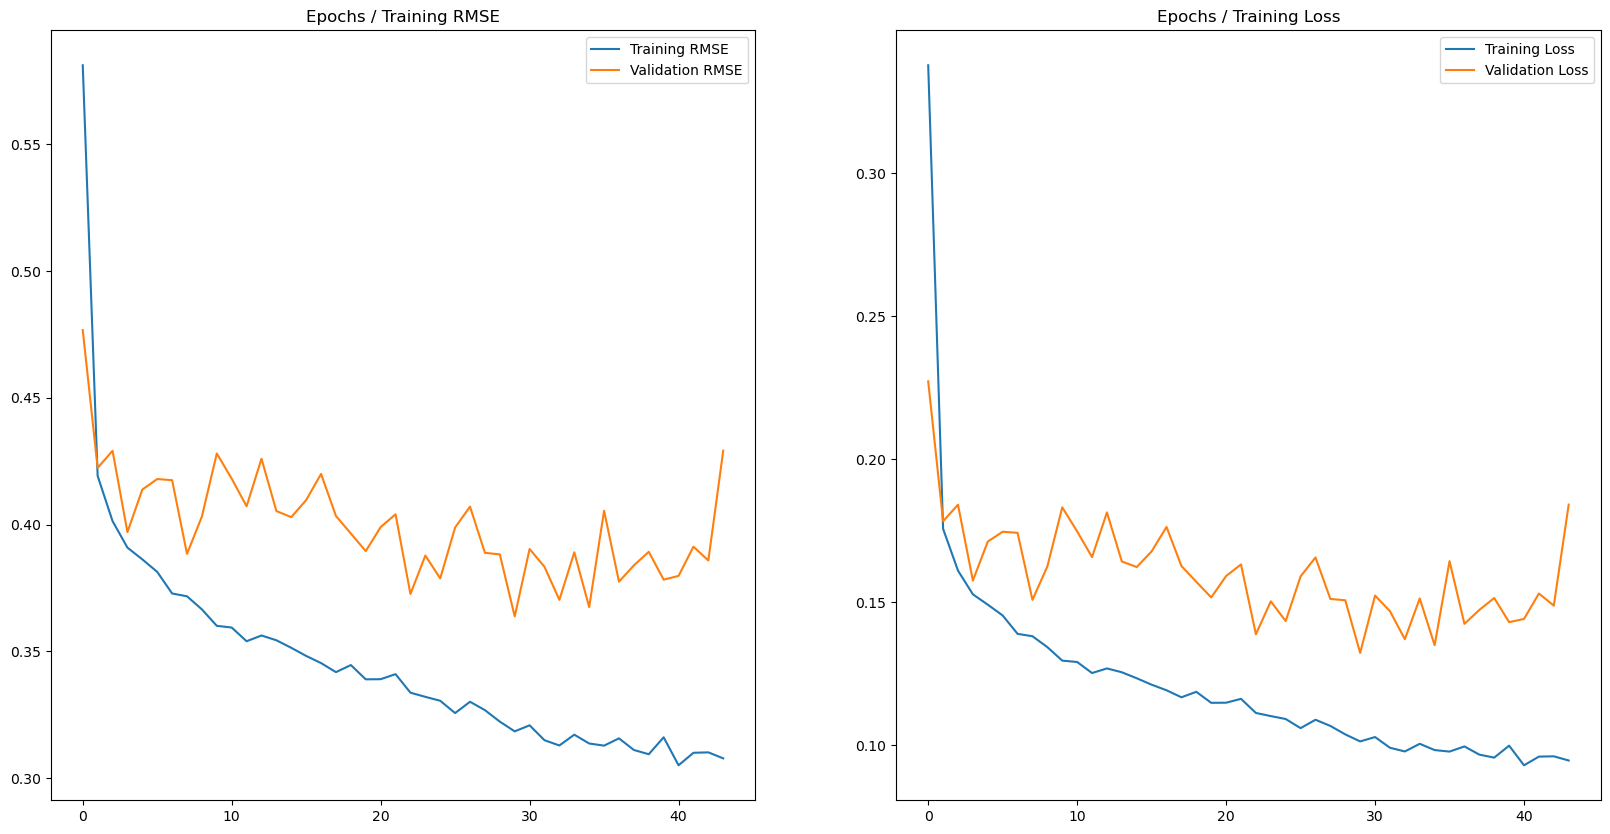

12/12 [==============================] - 0s 897us/step


In [15]:
# I run the model, make the predictions and rescale them to the original shape

tf.keras.backend.clear_session()

history = mlp.fit(X_train_mlp, y_train_mlp, validation_data=(X_val_mlp, y_val_mlp), epochs=EPOCHS, verbose=1, batch_size=batch, callbacks=[early_stopping])

plot_model_rmse_and_loss(history)

y_pred_mlp = mlp.predict(X_test_mlp)                          

pred_rescaled_mlp = ss.inverse_transform(y_pred_mlp)

#    return history, pred_rescaled

In [17]:
# I scale back the original y_test

mlp_test_rescaled = ss.inverse_transform(y_test_mlp)

In [18]:
# I plot the predictions and calculate the rmse

rmse_mlp = sqrt(np.mean((mlp_test_rescaled - pred_rescaled_mlp)**2))
print('Mean Squared Error:', rmse_mlp)

Mean Squared Error: 52523.44488505011


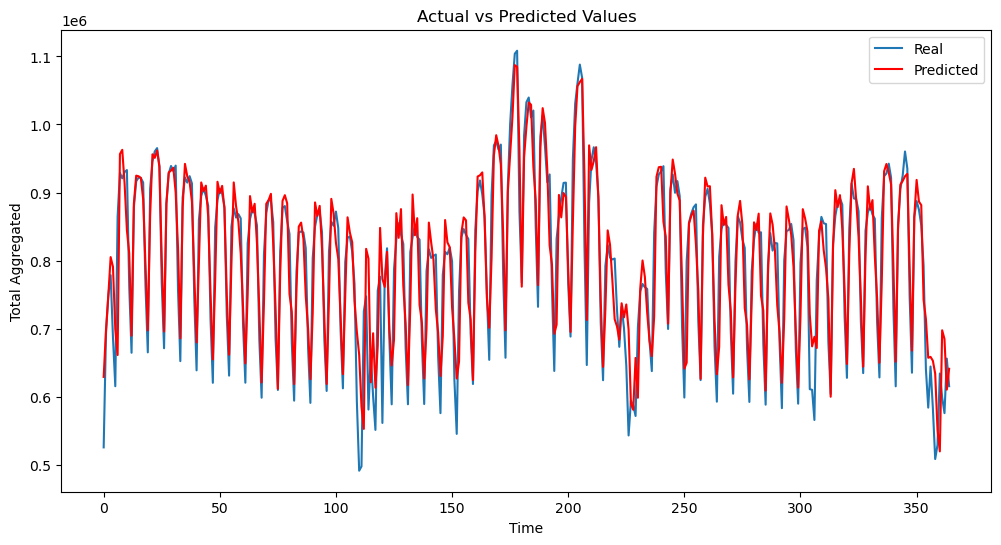

In [20]:
plot_preds_vs_actual(mlp_test_rescaled, pred_rescaled_mlp)

### LSTM

In [21]:
# I write a function that creates sequences of data for the LSTM cell, since the network works differently from the MLP. 
# the function creates a list of lagged observation for each value in the y

def create_sequence(selected_array, lags):
    X, y = list(), list()
    for i in range(len(selected_array)):
        # find the end of this pattern
        end_ix = i + lags
        # check if we are beyond the sequence
        if end_ix > len(selected_array)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = selected_array[i:end_ix], selected_array[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [22]:
# I create a different scaled array since LSTM works better with minmax scaling

scaled_array2 = create_scaled_array(data_task, energy, '2018', mms)

In [23]:
# I create train, validation and test set using the previous function

X_train_lstm, y_train_lstm = create_sequence(scaled_array2[:int(len(data_task)-732)], 7)
X_val_lstm, y_val_lstm = create_sequence(scaled_array2[int(len(data_task)-732):int(len(data_task)-366)], 7)
X_test_lstm, y_test_lstm = create_sequence(scaled_array2[int(len(data_task)-366):], 7)

In [28]:
# Define the hyperparamters of the NN

loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
EPOCHS = 200
batch = 16

In [24]:
input_shape1 = X_train_lstm.shape[-2:]

In [29]:
# I define the model, run it and make the predicitons as before

tf.keras.backend.clear_session()

lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=input_shape1),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Dense(1),
])

lstm.summary()

lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 10)             480       
                                                                 
 lstm_1 (LSTM)               (None, 7, 10)             840       
                                                                 
 flatten (Flatten)           (None, 70)                0         
                                                                 
 dense (Dense)               (None, 1)                 71        
                                                                 
Total params: 1,391
Trainable params: 1,391
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200


274/274 [==============================] - 5s 9ms/step - loss: 0.0285 - root_mean_squared_error: 0.1687 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1520
Epoch 2/200
274/274 [==============================] - 2s 8ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 3/200
274/274 [==============================] - 2s 9ms/step - loss: 0.0109 - root_mean_squared_error: 0.1043 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 4/200
274/274 [==============================] - 2s 8ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 5/200
274/274 [==============================] - 2s 8ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018
Epoch 6/200
274/274 [==============================] - 2s 8ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0092 - val_root_m

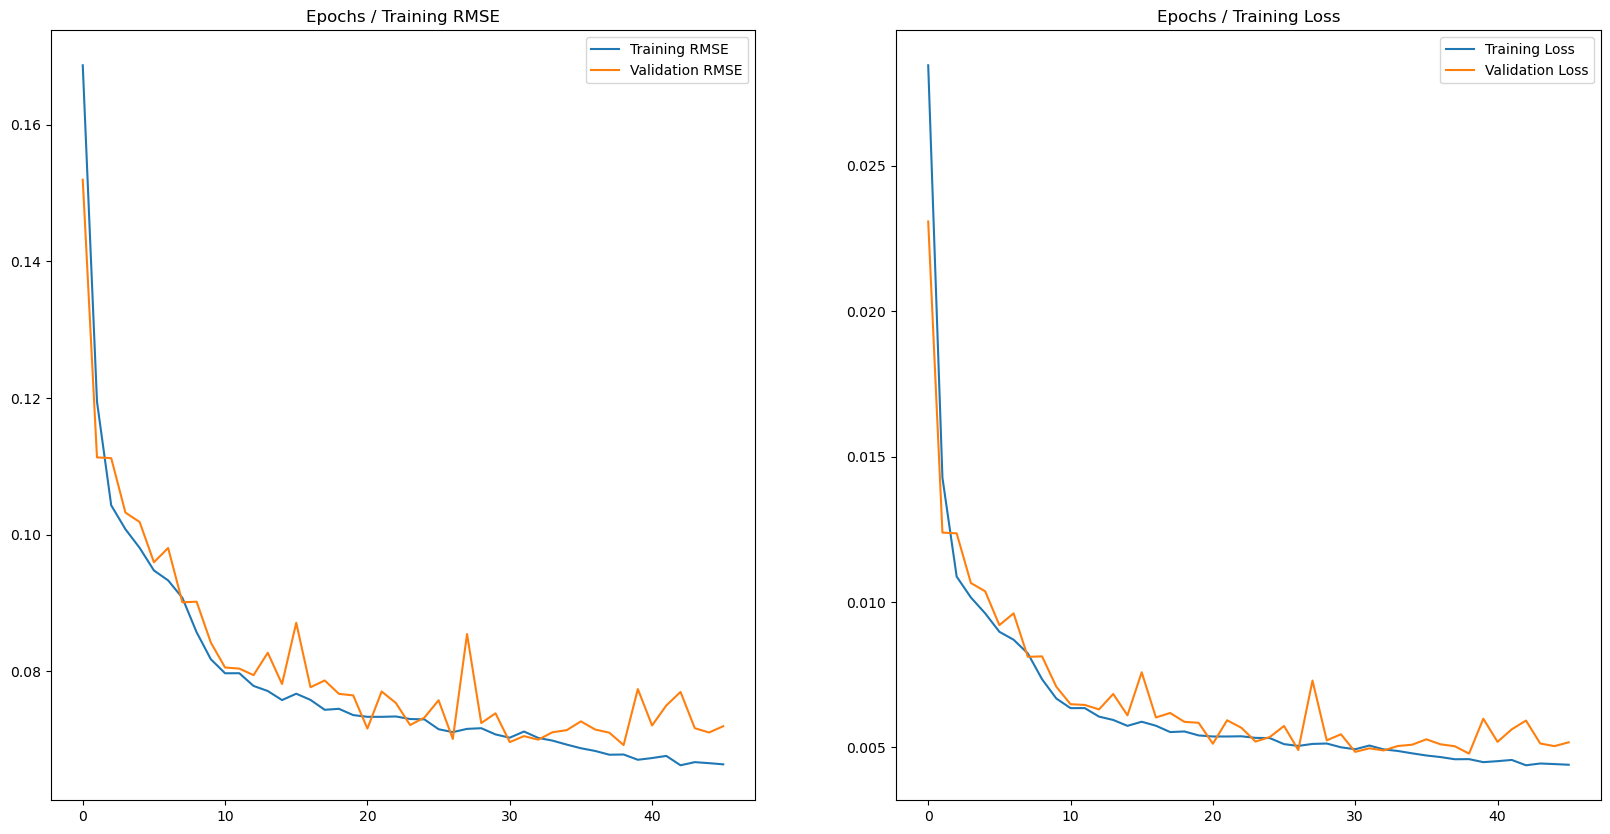

In [30]:
history_lstm = lstm.fit(X_train_lstm, y_train_lstm, validation_data=(X_val_lstm, y_val_lstm), epochs=EPOCHS, verbose=1, batch_size=batch, callbacks=[early_stopping])

plot_model_rmse_and_loss(history_lstm)

In [31]:
# time for predictions

y_pred_lstm = lstm.predict(X_test_lstm)                          

pred_rescaled_lstm = mms.inverse_transform(y_pred_lstm)

12/12 [==============================] - 1s 2ms/step


In [32]:
# I scale back the original y_test

lstm_test_rescaled = mms.inverse_transform(y_test_lstm)

In [33]:
# plot of the results and rmse of the LSTM

rmse_lstm = sqrt(np.mean((lstm_test_rescaled - pred_rescaled_lstm)**2))
print('Mean Squared Error:', rmse_lstm)

Mean Squared Error: 47824.14219140643


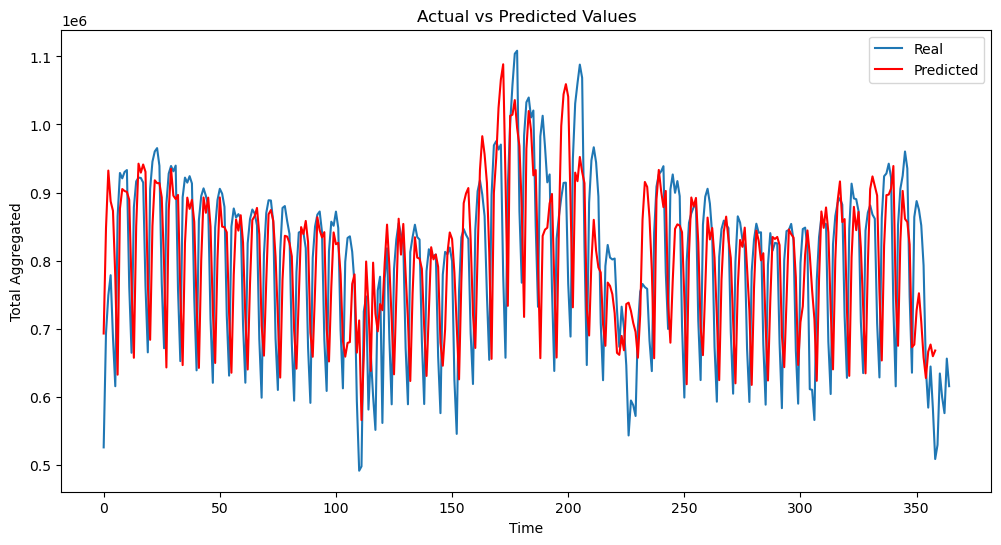

In [34]:
plot_preds_vs_actual(data_task.Load['2019'].values, pred_rescaled_lstm)

Both the models performed well in tackling the time series forecasting task. By looking at the error term (RMSE), the LSTM provided better accuracy.
However, in both cases the networks managed to follow the pattern inside the data and provide predictions that matched the actual behaviour of the series.
Of course, the models need several improvements, but the problem of non stationarity has been tackled efficiently.